In [75]:
from openai import OpenAI

client = OpenAI()
embedding_model = "text-embedding-ada-002"

In [ ]:
res = client.embeddings.create(input="今天晚上吃炒土豆丝", model=embedding_model)
print(type(res))
print(type(res.data))
print(len(res.data))
print(res.data[0].embedding)

In [6]:
print(len(res.data[0].embedding))

1536


In [2]:
import pandas as pd
import tiktoken


In [6]:
input_path='data/fine_food_reviews_1k.csv'
df = pd.read_csv(input_path,index_col=0) #使用给定的列作为索引
df = df[["Time","ProductId","UserId","Score","Summary","Text"]]
df = df.dropna()  #删除包含缺失的行或列

df["combind"] = (
    "Title" + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(2)
    
 

,Time,ProductId,UserId,Score,Summary,Text,combind
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Titlewhere does one start...and stop... with ...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",TitleArrived in pieces; Content: Not pleased a...


In [7]:
df["combind"]

0      Titlewhere does one  start...and stop... with ...
1      TitleArrived in pieces; Content: Not pleased a...
2      TitleIt isn't blanc mange, but isn't bad . . ....
3      TitleThese also have SALT and it's not sea sal...
4      TitleHappy with the product; Content: My dog w...
                             ...                        
995    TitleDelicious!; Content: I have ordered these...
996    TitleGood Training Treat; Content: My dog will...
997    TitleJamica Me Crazy Coffee; Content: Wolfgang...
998    TitleParty Peanuts; Content: Great product for...
999    TitleI love Maui Coffee!; Content: My first ex...
Name: combind, Length: 1000, dtype: object

In [70]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"

# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"

# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

In [11]:
embedding_path = "data/fine_food_reviews_with_embeddings_1k.csv"
df_embedded = pd.read_csv(embedding_path,index_col=0)

df_embedded["embedding"].head(2)

12    [-0.0005399271612986922, -0.004124758299440145...
13    [0.0068963742814958096, 0.0167608093470335, -0...
Name: embedding, dtype: object

In [12]:
len(df_embedded["embedding"][0])

34410

In [13]:
type(df_embedded["embedding"][0])

str

In [15]:
# 将字符串转换为向量
import ast
df_embedded["embedding_vec"] = df_embedded["embedding"].apply(ast.literal_eval)

In [16]:
len(df_embedded["embedding_vec"][0])

1536

In [17]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145..."
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0..."


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.manifold import TSNE

In [19]:
type(df_embedded["embedding_vec"])

pandas.core.series.Series

In [22]:
# 首先，确保你的嵌入向量都是等长的
assert df_embedded["embedding_vec"].apply(len).nunique() ==1

In [25]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embedded["embedding_vec"].values)
len(matrix)

1000

In [26]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne =TSNE(n_components=2,perplexity=15,random_state=42,init='random',learning_rate=200)


In [27]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)


In [29]:
colors = ["red","darkorange","gold","turquoise","darkgreen"]
x = [ x for x,y in vis_dims]
y = [ y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embedded.Score.values - 1

In [30]:
colormap = matplotlib.colors.ListedColormap(colors)
print(len(vis_dims), len(df_embedded.Score.values))

1000 1000


Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

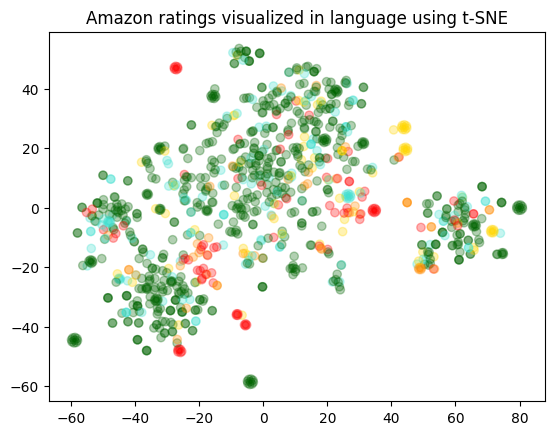

In [32]:
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x,y,c=color_indices,cmap=colormap,alpha=0.3)
plt.title("Amazon ratings visualized in language using t-SNE")


In [39]:
print(len(matrix),len(matrix[0]))
print(matrix[0])

1000 1536
[-0.00053993 -0.00412476  0.00852472 ... -0.00180899 -0.03444794
 -0.03425999]


In [61]:
import numpy as np
from sklearn.cluster import KMeans

n_clusters = 3
# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
# n_init=10 消除警告 'FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4'
kmeans = KMeans(n_clusters=n_clusters,
                init='k-means++',
                random_state=42,
                n_init=10)


kmeans.fit(matrix)

df_embedded['Cluster'] = kmeans.labels_

In [62]:
df_embedded['Cluster']

12     0
13     0
14     0
15     2
16     0
      ..
447    0
436    0
437    1
438    0
439    0
Name: Cluster, Length: 1000, dtype: int32

In [63]:
df_embedded.head(2)

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,embedding_vec,Cluster
12,B000K8T3OQ,AK43Y4WT6FFR3,1,Broken in a million pieces,Chips were broken into small pieces. Problem i...,Title: Broken in a million pieces; Content: Ch...,120,"[-0.0005399271612986922, -0.004124758299440145...","[-0.0005399271612986922, -0.004124758299440145...",0
13,B0051C0J6M,AWFA8N9IXELVH,1,Deceptive description,On Oct 9 I ordered from a different vendor the...,Title: Deceptive description; Content: On Oct ...,157,"[0.0068963742814958096, 0.0167608093470335, -0...","[0.0068963742814958096, 0.0167608093470335, -0...",0


In [64]:
colors = ["red","green","blue","purple","orange"]
tsne_model = TSNE(n_components=2,random_state=42)
vis_data= tsne_model.fit_transform(matrix)


In [65]:
print(len(vis_data),type(vis_data))
print(vis_data[0])

1000 <class 'numpy.ndarray'>
[-38.002148  -8.779585]


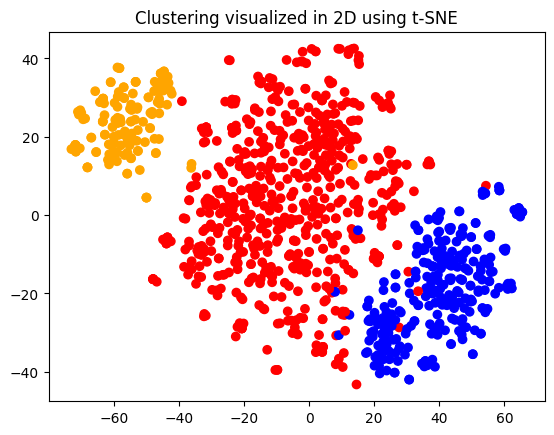

In [66]:
x = vis_data[:,0]
y = vis_data[:,1]

color_indices = df_embedded['Cluster'].values
colormap = matplotlib.colors.ListedColormap(colors)

plt.scatter(x,y,c=color_indices,cmap=colormap)
plt.title("Clustering visualized in 2D using t-SNE")
plt.show()

In [68]:
def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [69]:
type(df_embedded["embedding_vec"][0])

list

In [80]:
print(df.columns,df_embedded.columns)

Index(['Time', 'ProductId', 'UserId', 'Score', 'Summary', 'Text', 'combind'], dtype='object') Index(['ProductId', 'UserId', 'Score', 'Summary', 'Text', 'combined',
       'n_tokens', 'embedding', 'embedding_vec', 'Cluster'],
      dtype='object')


In [81]:
def embedding_text(text,model=embedding_model):
    res = client.embeddings.create(input=text,model=model)
    return res.data[0].embedding

In [88]:
def search_reviews(df, product_desc,n=3,pprint=True):
    product_embedding = embedding_text(product_desc)
    df_embedded['similarity'] = df_embedded.embedding_vec.apply(lambda x: cosine_similarity(x,product_embedding))
    results = (
      df_embedded.sort_values("similarity",ascending=False).
        head(n).
        combined.str.replace("Title: ","").
        str.replace("; Content:",": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [89]:
res = search_reviews(df,product_desc='egg noodles',n=3)

Best cup of noodles ever!:  Tried many (from all over the world) different types of packaged quick-meal type noodles.  These are by far the best I've had.

Handy:  Love the idea of ready in a minute pasta and for that alone this product gets praise.  The pasta is whole grain so that's a big plus and it actually comes out al dente.  The vegetable marinara

Great stuff:  I use this to make a broth for noodles and soup. it reminds me of the days I spent in Japan. easy to use.



# 